# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

# ETL & EDA

In [2]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  
from xgboost import XGBClassifier
from bs4 import BeautifulSoup
from fuzzywuzzy import process

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

# Regular Season Data

In [3]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

In [4]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

All the dtypes look correct, so lets move on to our analysis

In [5]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [6]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [7]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

We can look at other factors as well:

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

# Tournament Data

In [8]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,15,14,19,7,20,9,9,7,0,13
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,6,11,8,24,12,14,5,3,11
1178,2021,152,1124,78,1222,59,N,0,29,55,...,19,11,16,13,12,10,10,4,5,10
1179,2021,152,1211,93,1417,90,N,1,37,63,...,17,14,21,7,24,21,9,4,1,16


In [9]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [10]:
#Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [11]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [12]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [13]:
detailed_tourney_results.dtypes

Season          int64
DayNum          int64
WTeamID         int64
WScore          int64
LTeamID         int64
LScore          int64
WLoc           object
NumOT           int64
WFGM            int64
WFGA            int64
WFGM3           int64
WFGA3           int64
WFTM            int64
WFTA            int64
WOR             int64
WDR             int64
WAst            int64
WTO             int64
WStl            int64
WBlk            int64
WPF             int64
LFGM            int64
LFGA            int64
LFGM3           int64
LFGA3           int64
LFTM            int64
LFTA            int64
LOR             int64
LDR             int64
LAst            int64
LTO             int64
LStl            int64
LBlk            int64
LPF             int64
SCOREDIFF       int64
WFGPCT        float64
W3PCT         float64
WFTPCT        float64
WORBCHANCE      int64
WORPCT        float64
LFGPCT        float64
L3PCT         float64
LFTPCT        float64
LORBCHANCE      int64
LORPCT        float64
dtype: obj

In [14]:
detailed_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333


# Merge with MTeams.csv to get TeamName

In [15]:
# mteams_df = pd.read_csv('MTeams.csv')

# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
# merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
# merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_names = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_names

In [16]:
# Load the MTeams.csv file
mteams_df = pd.read_csv('MTeams.csv')

# Assuming detailed_tourney_results is your dataframe containing data about the tournament results
# and you have columns WTeamID and LTeamID in detailed_tourney_results

# Merge for WTeamID
merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_names = pd.concat([merged_df_winning, merged_df_losing[['TeamName2']]], axis=1)


# Display the resulting DataFrame
merged_df_names


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,TeamID,TeamName1,FirstD1Season,LastD1Season,TeamName2
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.432836,0.387097,0.451613,47,0.361702,1421,UNC Asheville,1987,2022,TX Southern
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.312500,0.250000,1.000000,44,0.181818,1112,Arizona,1985,2022,Vermont
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.362319,0.250000,0.666667,47,0.425532,1113,Arizona St,1985,2022,Memphis
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.450000,0.411765,0.705882,34,0.411765,1141,C Michigan,1985,2022,Creighton
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.446429,0.428571,0.750000,30,0.333333,1143,California,1985,2022,NC State
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,0.387097,0.266667,0.736842,34,0.205882,1211,Gonzaga,1985,2022,USC
1177,2021,148,1417,51,1276,49,N,0,21,54,...,0.392157,0.272727,0.545455,29,0.275862,1417,UCLA,1985,2022,Michigan
1178,2021,152,1124,78,1222,59,N,0,29,55,...,0.381818,0.315789,0.687500,30,0.433333,1124,Baylor,1985,2022,Houston
1179,2021,152,1211,93,1417,90,N,1,37,63,...,0.576271,0.470588,0.666667,26,0.269231,1211,Gonzaga,1985,2022,UCLA


# Merge with MNCAATourneySeeds.csv to get seeds of each team

In [17]:
# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_winning.rename(columns={'Seed': 'WTeamSeed'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_losing.rename(columns={'Seed': 'LTeamSeed'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_seeds

In [18]:
# Load the seeds dataframe
seeds_df = pd.read_csv('MNCAATourneySeeds.csv')

# Extract the integer part from the Seed column and store it as integer
seeds_df['Seed_correct'] = seeds_df['Seed'].str.extract('(\d+)').astype(int)
seeds_df

,Season,Seed,TeamID,Seed_correct
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5
...,...,...,...,...
2349,2021,Z12,1457,12
2350,2021,Z13,1317,13
2351,2021,Z14,1159,14
2352,2021,Z15,1331,15


In [19]:
# Assuming merged_df_names is your already merged dataframe containing team names
# seeds_df is your dataframe containing team IDs and their associated seed in a tournament
# and you have columns WTeamID and LTeamID in merged_df_names

# Merge for WTeamID
merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_winning.rename(columns={'Seed_correct': 'WTeamSeedCorr'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_losing.rename(columns={'Seed_correct': 'LTeamSeedCorr'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing[['LTeamSeedCorr']]], axis=1)

# Drop unnecessary columns from the losing team dataframe
#merged_df_seeds.drop(['TeamID', 'TeamName'], axis=1, inplace=True)

# Display the resulting DataFrame
merged_df_seeds


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LORPCT,TeamID_x,TeamName1,FirstD1Season,LastD1Season,TeamName2,Seed,TeamID_y,WTeamSeedCorr,LTeamSeedCorr
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.361702,1421,UNC Asheville,1987,2022,TX Southern,X16b,1421,16,16
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.181818,1112,Arizona,1985,2022,Vermont,Z01,1112,1,16
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.425532,1113,Arizona St,1985,2022,Memphis,Z10,1113,10,7
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.411765,1141,C Michigan,1985,2022,Creighton,Z11,1141,11,6
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.333333,1143,California,1985,2022,NC State,W08,1143,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,0.205882,1211,Gonzaga,1985,2022,USC,X01,1211,1,6
1177,2021,148,1417,51,1276,49,N,0,21,54,...,0.275862,1417,UCLA,1985,2022,Michigan,W11b,1417,11,1
1178,2021,152,1124,78,1222,59,N,0,29,55,...,0.433333,1124,Baylor,1985,2022,Houston,Z01,1124,1,2
1179,2021,152,1211,93,1417,90,N,1,37,63,...,0.269231,1211,Gonzaga,1985,2022,UCLA,X01,1211,1,11


In [20]:
merged_df_seeds.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr'],
      dtype='object')

# Merge 247 data (stars)

In [21]:
# import requests
# from bs4 import BeautifulSoup
# import csv
# import re

# def scrape_season(year):
#     url = f"https://247sports.com/Season/{year}-Basketball/RecruitRankings/?InstitutionGroup=HighSchool"
#     print(f"Scraping URL: {url}")

#     headers = {
#         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#     except requests.exceptions.HTTPError as err:
#         print(f"HTTP Error: {err}")
#         return
#     except Exception as err:
#         print(f"Error occurred: {err}")
#         return

#     if not response.text:
#         print(f"No data received for {year}, skipping...")
#         return

#     soup = BeautifulSoup(response.text, 'html.parser')
#     recruits = soup.find_all('li', class_='rankings-page__list-item')

#     if not recruits:
#         print(f"No recruits found for {year}, check if page structure is different.")
#         return

#     with open(f'recruits_{year}.csv', 'w', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Rank', 'Player', 'High School', 'Position', 'Height / Weight', 'Rating', 'Team'])

#         for recruit in recruits:
#             rank = recruit.find('div', class_='primary').get_text(strip=True)
#             name = recruit.find('a', class_='rankings-page__name-link').get_text(strip=True)
#             high_school = recruit.find('div', class_='recruit').get_text(strip=True)
#             position = recruit.find('div', class_='position').get_text(strip=True)
#             height_weight = recruit.find('div', class_='metrics').get_text(strip=True)
#             rating_info = recruit.find('div', class_='rating').get_text(strip=True)
#             match = re.search(r'\b(100|[1-9]?[0-9])', rating_info)
#             rating = match.group(0) if match else 'N/A'
            
#             # Extract team name from alt attribute of img tag within a tag within div with class "status"
#             status_div = recruit.find('div', class_='status')
#             team_alt = 'N/A'
#             if status_div:
#                 img_link = status_div.find('a', class_='img-link')
#                 if img_link:
#                     img_tag = img_link.find('img')
#                     if img_tag:
#                         team_alt = img_tag.get('alt')

#             writer.writerow([rank, name, high_school, position, height_weight, rating, team_alt])

# # Loop through the years
# for year in range(2011, 2025):
#     scrape_season(year)

In [22]:
playerRating_df = pd.DataFrame()

# Loop through each year, read the CSV, add a 'Year' column, and append to the main DataFrame
for year in range(2011, 2025):
    file_name = f'recruits_{year}.csv'
    if os.path.exists(file_name):  # Check if the file exists
        df = pd.read_csv(file_name)
        df['Year'] = year  # Add a column for the year
        playerRating_df = pd.concat([playerRating_df, df], ignore_index=True)

# Save the combined data to a new CSV file
playerRating_df.to_csv('combined_recruits.csv', index=False)

# If you want to see the DataFrame
playerRating_df

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011
...,...,...,...,...,...,...,...,...
2925,146,Bryce Dortch,Bryce DortchBrimmer And May School (Chestnut H...,PF,6-8 / 190,88,Rutgers,2024
2926,147,Angelo Ciaravino,"Angelo CiaravinoMount Carmel (Chicago, IL)",SF,6-5 / 175,88,Northwestern,2024
2927,148,Malcolm Thomas,"Malcolm ThomasDeMatha Catholic (Hyattsville, MD)",PF,6-8 / 195,88,Villanova,2024
2928,149,Chris Tadjo,Chris TadjoNBA Academy Latin America (Montreal...,PF,6-8 / 220,88,Iowa,2024


In [23]:
def rating_to_stars(rating):
    if 100 >= rating >= 98:
        return 5
    elif 97 >= rating >= 94:
        return 4
    elif 93 >= rating >= 0:
        return 3
    else:
        return None  # or some default value for ratings outside the specified ranges

# Apply the function to the 'Rating' column to create the 'Star' column
playerRating_df['Stars'] = playerRating_df['Rating'].apply(rating_to_stars)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [24]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
print(top_players)

Year
2011    70
2012    10
2013    83
2014    87
2015    87
2016    10
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64


In [25]:
def adjust_rating(row):
    if row['Rating'] == 10:
        return 101
    elif row['Player'] == 'Josh Jackson':
        return 102
    else:
        return row['Rating']

# Apply the function to each row
playerRating_df['Rating'] = playerRating_df.apply(adjust_rating, axis=1)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()


,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [26]:
columns = ['Rank', 'Player', 'Team', 'Year', 'Stars']

playerRating_df = playerRating_df[columns]
playerRating_df

,Rank,Player,Team,Year,Stars
0,1,Anthony Davis,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,Kentucky,2011,5
2,3,Austin Rivers,Duke,2011,5
3,4,Bradley Beal,Florida,2011,5
4,5,Quincy Miller,Baylor,2011,5
...,...,...,...,...,...
2925,146,Bryce Dortch,Rutgers,2024,3
2926,147,Angelo Ciaravino,Northwestern,2024,3
2927,148,Malcolm Thomas,Villanova,2024,3
2928,149,Chris Tadjo,Iowa,2024,3


In [27]:
playerRating_df

,Rank,Player,Team,Year,Stars
0,1,Anthony Davis,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,Kentucky,2011,5
2,3,Austin Rivers,Duke,2011,5
3,4,Bradley Beal,Florida,2011,5
4,5,Quincy Miller,Baylor,2011,5
...,...,...,...,...,...
2925,146,Bryce Dortch,Rutgers,2024,3
2926,147,Angelo Ciaravino,Northwestern,2024,3
2927,148,Malcolm Thomas,Villanova,2024,3
2928,149,Chris Tadjo,Iowa,2024,3


In [28]:
# Group the DataFrame by 'Team' and 'Year', and count occurrences of 3, 4, and 5 stars
team_year_counts = playerRating_df.groupby(['Team', 'Year'])['Stars'].value_counts().unstack(fill_value=0)

# Calculate the total stars by multiplying the count of each star rating by its corresponding rating
total_stars = (team_year_counts[[3, 4, 5]] * [3, 4, 5]).sum(axis=1)

# Select only the columns corresponding to 3, 4, and 5 stars
byTeamStars = team_year_counts[[3, 4, 5]]

# Add the total stars to the DataFrame
byTeamStars['Total Stars'] = total_stars

# Reset index to make 'Team' and 'Year' columns regular columns instead of index
byTeamStars = byTeamStars.reset_index()

# Rename columns for clarity
byTeamStars.columns.name = None  # Remove column name for better formatting
byTeamStars.columns = ['Team', 'Year', '3 Stars', '4 Stars', '5 Stars', 'Total Stars']

# Print the resulting DataFrame
byTeamStars

,Team,Year,3 Stars,4 Stars,5 Stars,Total Stars
0,Alabama,2011,2,2,0,14
1,Alabama,2012,0,0,1,5
2,Alabama,2013,1,1,0,7
3,Alabama,2014,2,2,0,14
4,Alabama,2015,3,0,0,9
...,...,...,...,...,...,...
1272,Xavier,2021,2,0,0,6
1273,Xavier,2022,2,0,0,6
1274,Xavier,2023,4,0,0,12
1275,Xavier,2024,1,0,0,3


In [29]:
# Convert the "Year" column to string type
byTeamStars['Year'] = byTeamStars['Year'].astype(str)

In [54]:
byTeamStars.dtypes

,Team,Year,3 Stars,4 Stars,5 Stars,Total Stars
0,Alabama,2011,2,2,0,14
1,Alabama,2012,0,0,1,5
2,Alabama,2013,1,1,0,7
3,Alabama,2014,2,2,0,14
4,Alabama,2015,3,0,0,9
...,...,...,...,...,...,...
1272,Xavier,2021,2,0,0,6
1273,Xavier,2022,2,0,0,6
1274,Xavier,2023,4,0,0,12
1275,Xavier,2024,1,0,0,3


In [31]:
merged_df_seeds.dtypes

Season             int64
DayNum             int64
WTeamID            int64
WScore             int64
LTeamID            int64
LScore             int64
WLoc              object
NumOT              int64
WFGM               int64
WFGA               int64
WFGM3              int64
WFGA3              int64
WFTM               int64
WFTA               int64
WOR                int64
WDR                int64
WAst               int64
WTO                int64
WStl               int64
WBlk               int64
WPF                int64
LFGM               int64
LFGA               int64
LFGM3              int64
LFGA3              int64
LFTM               int64
LFTA               int64
LOR                int64
LDR                int64
LAst               int64
LTO                int64
LStl               int64
LBlk               int64
LPF                int64
SCOREDIFF          int64
WFGPCT           float64
W3PCT            float64
WFTPCT           float64
WORBCHANCE         int64
WORPCT           float64


In [32]:
# # Perform fuzzy merge on merged_df_seeds['TeamName1'] and byTeamStars['Team']
# merged_df_seeds['TeamName1'] = merged_df_seeds['TeamName1'].apply(lambda x: process.extractOne(x, byTeamStars['Team'])[0])
# merged_df_seeds['TeamName2'] = merged_df_seeds['TeamName2'].apply(lambda x: process.extractOne(x, byTeamStars['Team'])[0])

# # Merge merged_df_seeds with byTeamStars on 'Team' and 'Year' columns
# merged_df_with_stars = pd.merge(merged_df_seeds, byTeamStars, left_on=['TeamName1', 'Season'], right_on=['Team', 'Year'], how='left')
# merged_df_with_stars = pd.merge(merged_df_with_stars, byTeamStars, left_on=['TeamName2', 'Season'], right_on=['Team', 'Year'], how='left', suffixes=('_Team1', '_Team2'))

# # Drop redundant columns after merging
# merged_df_with_stars.drop(['Team_Team1', 'Year_Team1', 'Team_Team2', 'Year_Team2'], axis=1, inplace=True)

# # Print the resulting DataFrame
# print(merged_df_with_stars)


# Many Nans because of year discrepancies, and Stars dont go back as far

In [46]:
# Define a function to perform fuzzy matching and merge the dataframes
def fuzzy_merge(df1, df2, key1, key2, threshold=90, limit=1):
    s = df2[key2].tolist()

    m = df1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df1['matches'] = m

    m2 = df1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df1['matches'] = m2

    return df1

# Perform fuzzy matching and merge the dataframes
merged_df_seeds = fuzzy_merge(merged_df_seeds, byTeamStars, 'TeamName1', 'Team', threshold=80)
merged_df_seeds = fuzzy_merge(merged_df_seeds, byTeamStars, 'TeamName2', 'Team', threshold=80)

# Drop the unnecessary columns from the merged_df_seeds
merged_df_seeds.drop(columns=['matches'], inplace=True)

# Merge the byTeamStars dataframe based on fuzzy matched team names and seasons (years)
merged_df_seeds = pd.merge(merged_df_seeds, byTeamStars, left_on=['TeamName1', 'Season'], right_on=['Team', 'Year'], how='left')
merged_df_seeds = pd.merge(merged_df_seeds, byTeamStars, left_on=['TeamName2', 'Season'], right_on=['Team', 'Year'], how='left', suffixes=('_1', '_2'))

# Drop the duplicate columns after merging
merged_df_seeds.drop(columns=['Team_1', 'Year_1', 'Team_2', 'Year_2'], inplace=True)

# Now you have the merged dataframe with data from byTeamStars for each team in each row of merged_df_seeds


In [55]:
# Access the row and display all columns and values
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(merged_df_seeds.iloc[0])


In [56]:
# # Assuming merged_df_seeds is your merged dataframe

# # Define the columns of interest
# columns_of_interest = ['3 Stars_1', '4 Stars_1', '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2', '5 Stars_2', 'Total Stars_2']

# # Count the number of NaN values in each column
# nan_counts = merged_df_seeds[columns_of_interest].isna().sum()

# # Print the results
# print("Number of NaN values in each column:")
# print(nan_counts)


Number of NaN values in each column:
3 Stars_1        692
4 Stars_1        692
5 Stars_1        692
Total Stars_1    692
3 Stars_2        848
4 Stars_2        848
5 Stars_2        848
Total Stars_2    848
dtype: int64


In [57]:
merged_df_with_stars.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', 'T1_T1_Team', 'T1_Year',
       'T1_T1_3 Stars', 'T1_T1_4 Stars', 'T1_T1_5 Stars', 'T1_T1_Total Stars',
       'T2_T2_Team', 'T2_Year', 'T2_T2_3 Stars', 'T2_T2_4 Stars',
       'T2_T2_5 Stars', 'T2_T2_Total Stars'],
      dtype='object')

# KENPOM

In [58]:
Pomeroy_data = 'kenpom_2023.csv'
pomeroy_df = pd.read_csv(Pomeroy_data)
pomeroy_df

# Display df
pomeroy_df

,Unnamed: 0,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3
...,...,...,...,...,...,...,...,...,...
4218,358,2023,Florida A&M;,89.0,110.7,64.1,-0.013,103.0,105.2
4219,359,2023,IUPUI,93.1,117.9,66.9,-0.079,102.1,108.0
4220,360,2023,Green Bay,90.6,116.6,65.1,0.031,104.4,106.9
4221,361,2023,LIU,85.7,114.3,72.0,-0.027,101.2,108.6


In [59]:
merged_df_seeds['Season'] = merged_df_seeds['Season'].astype(str)
merged_df_seeds.dtypes

Season            object
DayNum             int64
WTeamID            int64
WScore             int64
LTeamID            int64
                  ...   
Total Stars_1    float64
3 Stars_2        float64
4 Stars_2        float64
5 Stars_2        float64
Total Stars_2    float64
Length: 62, dtype: object

In [60]:
pomeroy_df['Season'] = pomeroy_df['Season'].astype(str)
pomeroy_df.dtypes

Unnamed: 0      int64
Season         object
TeamName       object
adj_o         float64
adj_d         float64
adj_tempo     float64
luck          float64
sos_adj_o     float64
sos_adj_d     float64
dtype: object

In [61]:

# Define a function to perform fuzzy matching and merge the dataframes
def fuzzy_merge(df1, df2, on, left_prefix, right_prefix):
    merged_df = df1.copy()
    for index, row in merged_df.iterrows():
        # Fuzzy match team names
        w_team_name = row['TeamName1']
        l_team_name = row['TeamName2']
        
        # Fuzzy match W team name
        w_match = process.extractOne(w_team_name, df2['TeamName'])
        l_match = process.extractOne(l_team_name, df2['TeamName'])
        
        # Find the corresponding rows in df2
        w_row = df2[df2['TeamName'] == w_match[0]]
        l_row = df2[df2['TeamName'] == l_match[0]]
        
        # Rename columns and merge for W team
        w_row.columns = [f"{right_prefix}W_{col}" if col != on else col for col in w_row.columns]
        for col in w_row.columns:
            merged_df.loc[index, f"{left_prefix}{col}"] = w_row[col].values[0]
        
        # Rename columns and merge for L team
        l_row.columns = [f"{right_prefix}L_{col}" if col != on else col for col in l_row.columns]
        for col in l_row.columns:
            merged_df.loc[index, f"{left_prefix}{col}"] = l_row[col].values[0]
    
    return merged_df

# Perform fuzzy merge and rename columns
merged_df = fuzzy_merge(merged_df_seeds, pomeroy_df, on='TeamName', left_prefix='W', right_prefix='Pomeroy_')

# Display the merged dataframe
merged_df


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,SCOREDIFF,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,TeamID_x,TeamName1,FirstD1Season,LastD1Season,TeamName2,Seed,TeamID_y,WTeamSeedCorr,LTeamSeedCorr,3 Stars_1,4 Stars_1,5 Stars_1,Total Stars_1,3 Stars_2,4 Stars_2,5 Stars_2,Total Stars_2,WPomeroy_W_Unnamed: 0,WPomeroy_W_Season,WTeamName,WPomeroy_W_adj_o,WPomeroy_W_adj_d,WPomeroy_W_adj_tempo,WPomeroy_W_luck,WPomeroy_W_sos_adj_o,WPomeroy_W_sos_adj_d,WPomeroy_L_Unnamed: 0,WPomeroy_L_Season,WPomeroy_L_adj_o,WPomeroy_L_adj_d,WPomeroy_L_adj_tempo,WPomeroy_L_luck,WPomeroy_L_sos_adj_o,WPomeroy_L_sos_adj_d
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702,1421,UNC Asheville,1987,2022,TX Southern,X16b,1421,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.0,2014,Southern,106.7,111.9,71.4,0.026,103.3,107.9,344.0,2011,80.0,114.8,66.0,-0.036,93.5,104.2
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818,1112,Arizona,1985,2022,Vermont,Z01,1112,1,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,2011,Vermont,115.1,95.5,66.9,0.078,105.8,98.9,135.0,2011,100.1,97.4,65.4,0.081,97.9,104.2
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532,1113,Arizona St,1985,2022,Memphis,Z10,1113,10,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,2011,Memphis,103.4,99.2,63.7,-0.009,106.4,97.7,100.0,2011,101.8,95.6,69.0,0.132,103.4,101.0
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765,1141,C Michigan,1985,2022,Creighton,Z11,1141,11,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,2011,Creighton,110.3,94.4,63.0,0.009,108.9,97.8,115.0,2011,105.4,100.9,64.4,-0.045,101.3,102.4
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333,1143,California,1985,2022,NC State,W08,1143,8,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,2011,N.C. State,110.3,97.9,68.6,0.026,107.4,96.9,72.0,2021,110.1,97.0,68.2,0.002,108.8,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,7,21,12,17,11,27,21,9,6,3,16,24,62,4,15,14,19,7,20,9,9,7,0,13,19,0.500000,0.333333,0.705882,31,0.354839,0.387097,0.266667,0.736842,34,0.205882,1211,Gonzaga,1985,2022,USC,X01,1211,1,6,0.0,2.0,2.0,18.0,1.0,0.0,0.0,3.0,28.0,2011,USC,110.4,91.6,67.7,-0.015,104.3,101.6,155.0,2014,102.2,101.8,70.3,-0.015,108.6,101.2
1177,2021,148,1417,51,1276,49,N,0,21,54,3,13,6,7,6,21,12,8,5,2,14,20,51,3,11,6,11,8,24,12,14,5,3,11,2,0.388889,0.230769,0.857143,30,0.200000,0.392157,0.272727,0.545455,29,0.275862,1417,UCLA,1985,2022,Michigan,W11b,1417,11,1,0.0,1.0,1.0,9.0,1.0,2.0,2.0,21.0,50.0,2011,Michigan,106.9,92.2,66.1,0.029,106.3,98.5,43.0,2011,110.3,94.4,63.0,0.009,108.9,97.8
1178,2021,152,1124,78,1222,59,N,0,29,55,11,24,9,13,11,17,23,8,6,0,18,21,55,6,19,11,16,13,12,10,10,4,5,10,19,0.527273,0.458333,0.692308,23,0.478261,0.381818,0.315789,0.687500,30,0.433333,1124,Baylor,1985,2022,Houston,Z01,1124,1,2,0.0,2.0,1.0,13.0,2.0,0.0,0.0,6.0,71.0,2011,Houston,107.0,96.2,66.2,-0.045,103.1,98.5,202.0,2011,100.8,105.1,66.9,0.006,101.5,100.7
1179,2021,152,1211,93,1417,90,N,

In [62]:
merged_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', '3 Stars_1', '4 Stars_1',
       '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2', '5 Stars_2',
       'Total Stars_2', 'WPomeroy_W_Unnamed: 0', 'WPomeroy_W_Season',
       'WTeamName', 'WPomeroy_W_adj_o', 'WPomeroy_W_adj_d',
       'WPomeroy_W_adj_tempo', 'WPomeroy_W_luck', 'WPomeroy_W_sos_adj_o',
       'WPomeroy_W_sos_adj_d', 'WPomeroy_L_Unnamed: 0', 'WPomeroy_L_Season',
       'WPomeroy_L_adj_o', 'WPomer

In [63]:
def remove_prefix(column_name):
    return column_name.replace('WPomeroy_', '')

# Rename columns
merged_df.columns = [remove_prefix(col) for col in merged_df.columns]

In [64]:
merged_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', '3 Stars_1', '4 Stars_1',
       '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2', '5 Stars_2',
       'Total Stars_2', 'W_Unnamed: 0', 'W_Season', 'WTeamName', 'W_adj_o',
       'W_adj_d', 'W_adj_tempo', 'W_luck', 'W_sos_adj_o', 'W_sos_adj_d',
       'L_Unnamed: 0', 'L_Season', 'L_adj_o', 'L_adj_d', 'L_adj_tempo',
       'L_luck', 'L_sos_adj_o', 'L_sos_adj_d'],
      dtype='object')

# Clean Data

In [65]:
import pandas as pd

def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['TeamID_x', 'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
                     'TeamID_y', 'W_Unnamed: 0', 'W_Season', 'WTeamName',
                     'L_Unnamed: 0', 'L_Season'], inplace=True)

    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                 'WTeamSeedCorr', 'LTeamSeedCorr', 'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
                 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT']]

    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['Outcome'] = (output['PointDiff'] > 0).astype(int)

    return output



In [66]:
#tournament_data = prepare_data(detailed_tourney_results)
tournament_data = prepare_data(merged_df)

In [67]:
tournament_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,SCOREDIFF,T1_FGPCT,T1_3PCT,T1_FTPCT,T1_ORBCHANCE,T1_ORPCT,T2_FGPCT,T2_3PCT,T2_FTPCT,T2_ORBCHANCE,T2_ORPCT,T1_TeamSeedCorr,T2_TeamSeedCorr,3 Stars_1,4 Stars_1,5 Stars_1,Total Stars_1,3 Stars_2,4 Stars_2,5 Stars_2,Total Stars_2,T1__adj_o,T1__adj_d,T1__adj_tempo,T1__luck,T1__sos_adj_o,T1__sos_adj_d,T2__adj_o,T2__adj_d,T2__adj_tempo,T2__luck,T2__sos_adj_o,T2__sos_adj_d,PointDiff,Outcome
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.7,111.9,71.4,0.026,103.3,107.9,80.0,114.8,66.0,-0.036,93.5,104.2,8,1
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818,1,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.1,95.5,66.9,0.078,105.8,98.9,100.1,97.4,65.4,0.081,97.9,104.2,29,1
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532,10,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.4,99.2,63.7,-0.009,106.4,97.7,101.8,95.6,69.0,0.132,103.4,101.0,13,1
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765,11,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,94.4,63.0,0.009,108.9,97.8,105.4,100.9,64.4,-0.045,101.3,102.4,6,1
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333,8,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,97.9,68.6,0.026,107.4,96.9,110.1,97.0,68.2,0.002,108.8,98.1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,148,1425,66,1211,85,0,0,24,62,4,15,14,19,7,20,9,9,7,0,13,33,66,7,21,12,17,11,27,21,9,6,3,16,19,0.387097,0.266667,0.736842,34,0.205882,0.500000,0.333333,0.705882,31,0.354839,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2358,2021,148,1276,49,1417,51,0,0,20,51,3,11,6,11,8,24,12,14,5,3,11,21,54,3,13,6,7,6,21,12,8,5,2,14,2,0.392157,0.272727,0.545455,29,0.275862,0.388889,0.230769,0.857143,30,0.200000,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,0
2359,2021,152,1222,59,1124,78,0,0,21,55,6,19,11,16,13,12,10,10,4,5,10,29,55,11,24,9,13,11,17,23,8,6,0,18,19,0.381818,0.315789,0.687500,30,0.433333,0.527273,0.458333,0.692308,23,0.478261,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2360,2021,152,1417,90,1211,93,0,1,34,59,8,17,14,21,7,24,21,9,4,1,16,37,63,7,21,12,20,4,19,25,10,8,3,16,3,0.576271,0.470588,0.666667,26,0.269231,0.587302,0.333333,0.600000,28,0.142857,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,0


In [68]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', '3 Stars_1',
       '4 Stars_1', '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2',
       '5 Stars_2', 'Total Stars_2', 'T1__adj_o', 'T1__adj_d', 'T1__adj_tempo',
       'T1__luck', 'T1__sos_adj_o', 'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d',
       'T2__adj_tempo', 'T2__luck', 'T2__sos_adj_o', 'T2__sos_adj_d',
       'PointDiff', 'Outcome'],
      dtype='object')

# Get Average amounts

In [72]:
# Choose the features that you want
# boxscore_cols = ['T1_Score', 'T2_Score',
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
#         'PointDiff','T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
#        'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
#        'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'T1__adj_o',
#        'T1__adj_d', 'T1__adj_tempo', 'T1__luck', 'T1__sos_adj_o',
#        'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d', 'T2__adj_tempo', 'T2__luck',
#        'T2__sos_adj_o', 'T2__sos_adj_d']

boxscore_cols = ['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', '3 Stars_1',
       '4 Stars_1', '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2',
       '5 Stars_2', 'Total Stars_2', 'T1__adj_o', 'T1__adj_d', 'T1__adj_tempo',
       'T1__luck', 'T1__sos_adj_o', 'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d',
       'T2__adj_tempo', 'T2__luck', 'T2__sos_adj_o', 'T2__sos_adj_d',
       'PointDiff', 'Outcome']

In [73]:
# Get season averages by team and yearb
funcs = [np.mean]
season_statistics = tournament_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics

,Season,T1_TeamID,Seasonmean,DayNummean,T1_TeamIDmean,T1_Scoremean,T2_TeamIDmean,T2_Scoremean,locationmean,NumOTmean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,SCOREDIFFmean,T1_FGPCTmean,T1_3PCTmean,T1_FTPCTmean,T1_ORBCHANCEmean,T1_ORPCTmean,T2_FGPCTmean,T2_3PCTmean,T2_FTPCTmean,T2_ORBCHANCEmean,T2_ORPCTmean,T1_TeamSeedCorrmean,T2_TeamSeedCorrmean,3 Stars_1mean,4 Stars_1mean,5 Stars_1mean,Total Stars_1mean,3 Stars_2mean,4 Stars_2mean,5 Stars_2mean,Total Stars_2mean,T1__adj_omean,T1__adj_dmean,T1__adj_tempomean,T1__luckmean,T1__sos_adj_omean,T1__sos_adj_dmean,T2__adj_omean,T2__adj_dmean,T2__adj_tempomean,T2__luckmean,T2__sos_adj_omean,T2__sos_adj_dmean,PointDiffmean,Outcomemean
0,2003,1104,2.003000e+03,137.0,1104.0,62.000000,1231.0,67.00,0.0,0.000000,22.000000,52.000000,5.00,12.000000,13.000000,16.000000,9.000000,20.000000,13.000000,8.000000,2.00,6.000000,21.000000,19.0,49.00,7.000000,18.000000,22.000000,26.000000,13.0,22.000000,15.00,8.000000,1.0,2.00,17.000000,5.0,0.423077,0.416667,0.812500,31.0,0.290323,0.387755,0.388889,0.846154,33.000000,0.393939,10.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.000000,0.000000
1,2003,1112,5.008001e+14,140.5,1112.0,84.750000,1303.0,73.75,0.0,0.500000,31.000000,67.750000,7.75,20.750000,15.000000,19.250000,13.500000,30.250000,18.750000,13.500000,9.25,4.500000,15.500000,27.0,66.75,8.250000,23.750000,11.500000,16.000000,12.0,25.500000,15.75,15.500000,8.5,4.25,19.000000,12.5,0.455256,0.387640,0.788530,39.0,0.343024,0.402656,0.339785,0.759921,42.250000,0.283499,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.1,95.5,66.9,0.078,105.8,98.9,111.1,94.666667,65.866667,0.053333,103.1,101.166667,11.000000,0.750000
2,2003,1113,1.001600e+07,137.0,1113.0,80.000000,1257.0,89.50,0.0,0.000000,29.500000,64.000000,5.00,14.500000,16.000000,22.500000,13.500000,20.500000,14.500000,10.000000,7.00,4.500000,20.000000,32.5,64.00,6.000000,18.500000,18.500000,27.500000,16.0,25.000000,16.00,12.500000,4.0,5.50,19.000000,22.5,0.465610,0.347619,0.711462,38.5,0.345139,0.520142,0.402778,0.671569,36.500000,0.443535,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.4,99.2,63.7,-0.009,106.4,97.7,101.8,95.600000,69.000000,0.132000,103.4,101.000000,-9.500000,0.500000
3,2003,1120,6.677334e+10,140.0,1120.0,70.333333,1409.0,68.00,0.0,0.333333,25.333333,58.666667,7.00,19.666667,12.666667,16.666667,13.333333,23.666667,12.333333,15.333333,6.00,5.333333,17.666667,23.0,58.00,6.333333,20.333333,15.666667,19.333333,14.0,21.666667,10.00,13.333333,8.0,6.00,19.666667,3.0,0.431913,0.351320,0.746305,35.0,0.380952,0.393207,0.318323,0.810516,37.666667,0.371368,10.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.3,100.5,65.8,0.001,100.8,99.8,111.6,97.550000,68.100000,0.026000,105.8,98.550000,2.333333,0.666667
4,2003,1122,2.003000e+03,137.0,1122.0,64.000000,1257.0,86.00,0.0,0.000000,24.000000,54.000000,2.00,21.000000,14.000000,22.000000,8.000000,21.000000,11.000000,18.000000,5.00,3.000000,18.000000,35.0,70.00,8.000000,24.000000,8.000000,13.000000,15.0,29.000000,18.00,12.000000,12.0,4.00,22.000000,22.0,0.444444,0.095238,0.636364,37.0,0.216216,0.500000,0.333333,0.615385,36.000000,0.416667,13.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2021,1439,2.021000e+03,137.0,1439.0,70.000000,1196.0,75.00,0.0,1.000000,24.000000,57.000000,7.00,23.000000,15.000000,21.000000,6.000000,16.000000,11.000000,11.000000,6.00,2.000000,24.000000,26.0,46.00,5.000000,13.

In [74]:
season_statistics.columns

Index(['Season', 'T1_TeamID', 'Seasonmean', 'DayNummean', 'T1_TeamIDmean',
       'T1_Scoremean', 'T2_TeamIDmean', 'T2_Scoremean', 'locationmean',
       'NumOTmean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T2_FGMmean',
       'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean',
       'T2_ORmean', 'T2_DRmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_Blkmean', 'T2_PFmean', 'SCOREDIFFmean', 'T1_FGPCTmean',
       'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean',
       'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean',
       'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean',
       '3 Stars_1mean', '4 Stars_1mean', '5 Stars_1mean', 'Total Stars_1mean',
       '3 Stars_2mean', '4 Stars_2mean', '5 Stars_2mean', 'Total Stars_2mean',
       'T1__adj_omean', 'T1__a

In [75]:
tournament_data = pd.merge(tournament_data, season_statistics, on = ['Season', 'T1_TeamID'], how = 'left')

In [76]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA',
       ...
       'T1__sos_adj_omean', 'T1__sos_adj_dmean', 'T2__adj_omean',
       'T2__adj_dmean', 'T2__adj_tempomean', 'T2__luckmean',
       'T2__sos_adj_omean', 'T2__sos_adj_dmean', 'PointDiffmean',
       'Outcomemean'],
      dtype='object', length=138)

In [77]:
# Calculate %FGM and %FGM3 for Team 1
tournament_data['T1_FG_PCT'] = (tournament_data['T1_FGMmean'] / tournament_data['T1_FGAmean']) * 100
tournament_data['T1_FGM3_PCT'] = (tournament_data['T1_FGM3mean'] / tournament_data['T1_FGA3mean']) * 100

# Calculate %FGM and %FGM3 for Team 2
tournament_data['T2_FG_PCT'] = (tournament_data['T2_FGMmean'] / tournament_data['T2_FGAmean']) * 100
tournament_data['T2_FGM3_PCT'] = (tournament_data['T2_FGM3mean'] / tournament_data['T2_FGA3mean']) * 100


In [89]:
# Convert DataFrame's columns to a list
columns_list = tournament_data.columns.tolist()

# Print the list of columns to display all columns
print(columns_list)


['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score', 'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE', 'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE', 'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', '3 Stars_1', '4 Stars_1', '5 Stars_1', 'Total Stars_1', '3 Stars_2', '4 Stars_2', '5 Stars_2', 'Total Stars_2', 'T1__adj_o', 'T1__adj_d', 'T1__adj_tempo', 'T1__luck', 'T1__sos_adj_o', 'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d', 'T2__adj_tempo', 'T2__luck', 'T2__sos_adj_o', 'T2__sos_adj_d', 'PointDiff', 'Outcome', 'Seasonmean', 'DayNummean', 'T1_TeamIDmean', 'T1_Scoremean', 'T2_TeamIDmean', 'T2_Scoremean', 'locationmean', 'NumOTmean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3me

# XGBoost RUN 1

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()


# Select the features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5433403805496829


In [91]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

ValueError: feature_names mismatch: ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', '5 Stars_2mean', '5 Stars_1mean'] ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']
expected T1_FGA3mean, T2_FGMmean, T2_FGAmean, T2_Stlmean, T1_FGAmean, T1_FGM3mean, T2_FGM3mean, T1_Stlmean, T2_TOmean, T2_FGA3mean, T1_TOmean, 5 Stars_1mean, T1_Astmean, T1_ORmean, T2_ORmean, T1_PFmean, T1_FGMmean, PointDiffmean, T2_Astmean, T2_Blkmean, 5 Stars_2mean in input data

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jimhaines/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimat

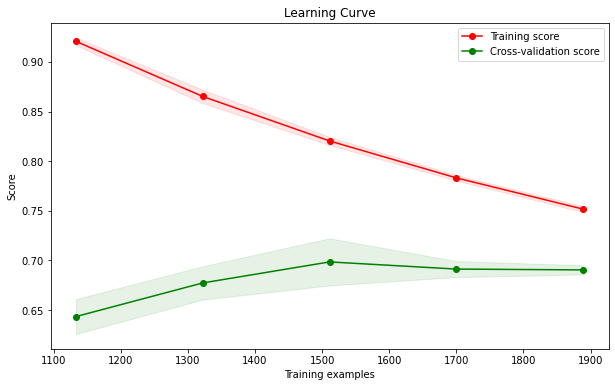

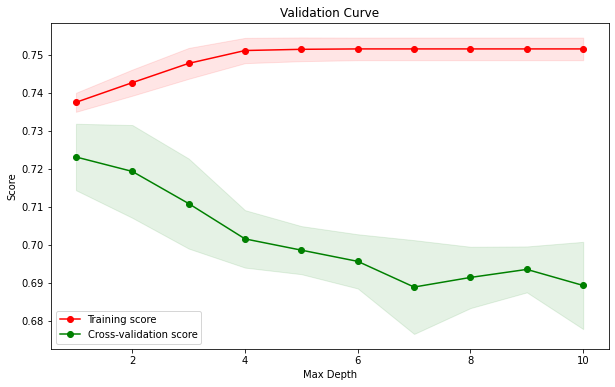

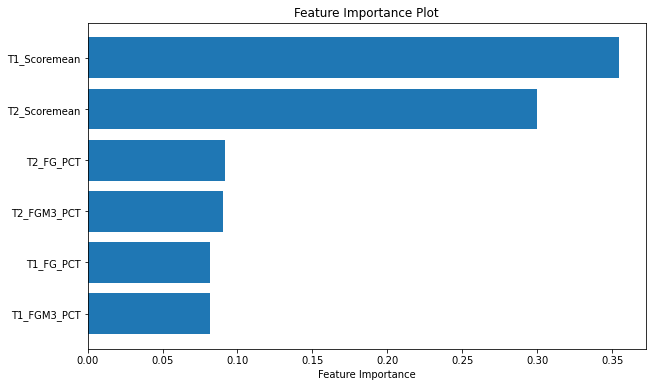

NameError: name 'XGBRegressor' is not defined

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Validation Curve
param_range = np.arange(1, 11)
train_scores, valid_scores = validation_curve(model, X, y, param_name="max_depth", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

# Feature Importance Plot
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

# Residual Plot (if regression)
if isinstance(model, XGBRegressor):
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()


# XGBoost RUN 2

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load your dataframe
df = tournament_data.copy()

# Add additional features if needed
# For example, you can add interactions between features, polynomial features, or other derived features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 
                     'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 
                     'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 
                     'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean','T1_FG_PCT',
                     'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', '5 Stars_2mean', '5 Stars_1mean']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6955602536997886


In [94]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

Brier Score: 0.2071043385364292


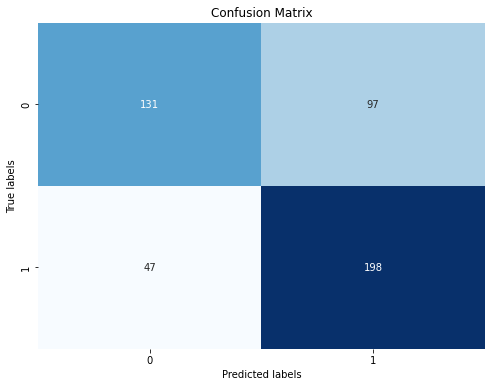

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


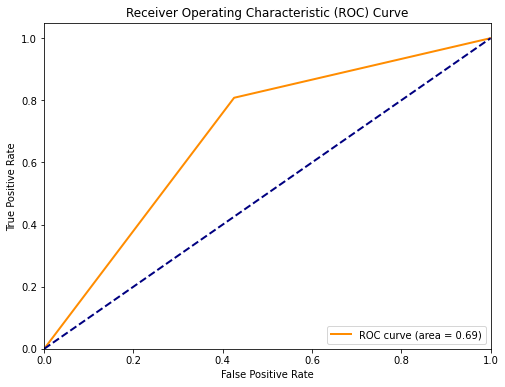

In [96]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


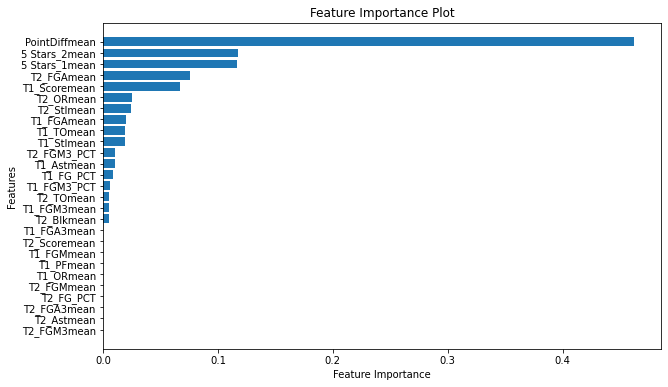

In [97]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


# XGBoost RUN 3

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeedCorr'] = label_encoder.fit_transform(df['T1_TeamSeedCorr'])
df['T2_TeamSeedCorr'] = label_encoder.fit_transform(df['T2_TeamSeedCorr'])


# Feature engineering: Add new features or transform existing ones
# For example, you can try adding interactions between features or polynomial features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', 'PointDiffmean', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Improved Accuracy:", accuracy)


Improved Accuracy: 0.7780126849894292


In [99]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)

Brier Score: 0.16126884059768873


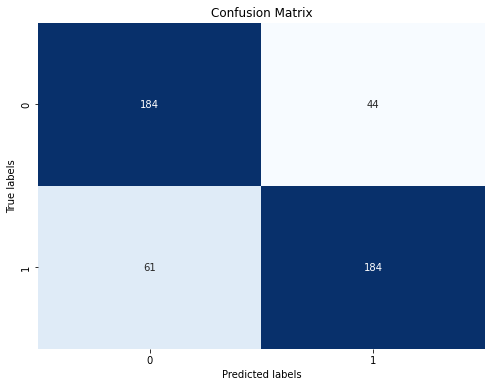

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


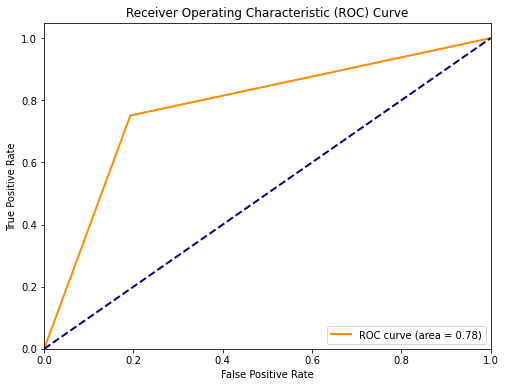

In [101]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


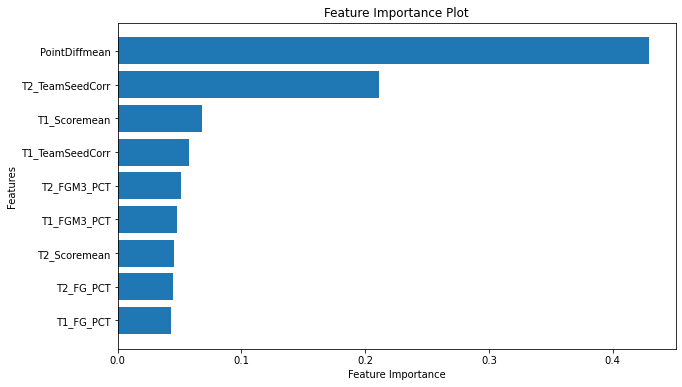

In [102]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


# Run 4

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeedCorr'] = label_encoder.fit_transform(df['T1_TeamSeedCorr'])
df['T2_TeamSeedCorr'] = label_encoder.fit_transform(df['T2_TeamSeedCorr'])


# Feature engineering: Add new features or transform existing ones
# For example, you can try adding interactions between features or polynomial features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean',
       'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean',
       'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean',
       'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean',
       'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean',
       'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean',
       'T1__adj_omean', 'T1__adj_dmean', 'T1__adj_tempomean', 'T1__luckmean',
       'T1__sos_adj_omean', 'T1__sos_adj_dmean', 'T2__adj_omean',
       'T2__adj_dmean', 'T2__adj_tempomean', 'T2__luckmean',
       'T2__sos_adj_omean', 'T2__sos_adj_dmean']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Improved Accuracy:", accuracy)

Improved Accuracy: 0.7230443974630021


In [104]:

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)

print("Brier Score:", brier_score)


Brier Score: 0.2038808674649359
